
# ALL FastAI Resnet 34 Classifier
The ALL FastAI Resnet 34 Classifier was created by   [Salvatore Raieli's](https://github.com/salvatorera)  and [Adam Milton-Barker](https://github.com/AdamMiltonBarker). The classifier provides a Google Colab notebook that uses FastAI with Resnet34 and ALL_IDB2 from the [Acute Lymphoblastic Leukemia Image Database for Image Processing dataset](https://homes.di.unimi.it/scotti/all/). 

# FastAI Resnet34 Classifier Project Contributors

- [Salvatore Raieli](https://github.com/salvatorera "Salvatore Raieli") - PhD Immunolgy / Bioinformaticia, Bologna, Italy
- [Adam Milton-Barker](https://github.com/AdamMiltonBarker "Adam Milton-Barker") - Bigfinite IoT Network Engineer & Intel Software Innovator, Barcelona, Spain

# Google Drive / Colab
This tutorial assumes you have access to [Google Drive](https://www.google.com/drive/) with enough space to save the dataset and related files. It is also assumed that you have access to [Google Colab](https://colab.research.google.com). 

# ALL_IDB dataset
You need to import **ALL_IDB2** from the [Acute Lymphoblastic Leukemia Image Database for Image Processing dataset](https://homes.di.unimi.it/scotti/all/) dataset, to do this you need to request permission from Fabio Scotti, the creator of the dataset. You can request permission by following the steps provided on [this page](https://homes.di.unimi.it/scotti/all/#download). 

The **ALL_IDB2** is a dataset composed by cropped images where a single linphocyte cell is placed in the center. As described in the website, the image are labeled with a progressive integer number and Y a boolean value (ImXXX_Y.jpg). Y equal to 1 is identifying to a blastic cell (cancer cell) where 0 is a normal cell (not cancer cell).  All the images with Y = 0 are coming from healthy individuals where Y = 1 are acquired from the ALL patient blood samples.

# Import data to Google Drive
Once you have permission you need to upload the negative and positive examples provided in **ALL_IDB2** to your Google Drive. In this tutorial we assume you have uploaded your copy of the dataset to a folder located on your Google drive with the location: *My Drive/fastai-v3/ALL_IDB2*. Once you have uploaded the dataset you can continue with this tutorial.

# Clone the AML-ALL-Classifiers repository
First we need to clone the repository so that we can upload this notebook to Google Colab. To do so you can clone the repository using the command below, alternatively you can "Download as ZIP" from the [repository homepage](https://github.com/AMLResearchProject/AML-ALL-Classifiers).


```
git clone https://github.com/AMLResearchProject/AML-ALL-Classifiers.git
```

Once you have cloned the repository, you will find this tutorial in the location: *AML-ALL-Classifiers/Python/_FastAI/Resnet50/ALL-FastAI-Resnet-50-a.ipynb*, you can now upload this to Google Colab and continue with this tutorial.

# Google Colab 

**You should now be running this tutorial on Google Colab, if not please read this tutorial from the beginning. **  

First we need import the Google Colab Drive library, mount our dataset drive from Google Drive, and set the path to the ALL_IDB2 folder on your drive. Run the following code block to do this. You will be asked to click a link that will authorize the application with the permissions it needs to mount your drive etc. Follow the steps and then past the authorization key into this application.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
dataset_dir = "/content/gdrive/My Drive/fastai-v3/ALL_IDB2"

Mounted at /content/gdrive


# Import required libraries
We need to import the relevant FastAI libraries, running the following code block with do this and get the paths to the dataset files.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
fileNames = get_image_files(dataset_dir)
fileNames[:5]

[PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im238_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im235_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im236_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im239_0.tif'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/ALL_IDB2/Im237_0.tif')]

# Import dataset
Now we need to import the dataset into this notebook. run the following code blocks to import the ALL_IDB2 dataset as a FastAI [DataBunch](https://docs.fast.ai/basic_data.html#DataBunch). In the ImageDataBunch.from_name_re function we can see that we pass the *dataset_dir* we created earlier in the tutorial, fileNames that we created earlier,  pattern for the files, some augmentation, the size of the images we need to match Resnet34 input sizes and the number of batches.  We then normalize the data using .normalize(imagenet_stats).

For more information about getting datasets ready with FastAI you can check out [this article](https://docs.fast.ai/vision.data.html#Quickly-get-your-data-ready-for-training).

In [0]:
np.random.seed(2)
pattern = r'/\w+_(\d)\.tif$'

In [0]:
data = ImageDataBunch.from_name_re(dataset_dir, fileNames, pattern, ds_tfms=get_transforms(), 
                                   size=224, bs=64).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (208 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,0,0,0,0
Path: /content/gdrive/My Drive/fastai-v3/ALL_IDB2;

Valid: LabelList (52 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/gdrive/My Drive/fastai-v3/ALL_IDB2;

Test: None

# data.show_batch()
Now we use the [data.show_batch()](https://docs.fast.ai/basic_data.html#DataBunch.show_batch) function to show a batch of our data. Run the following code block to do this and view the results.

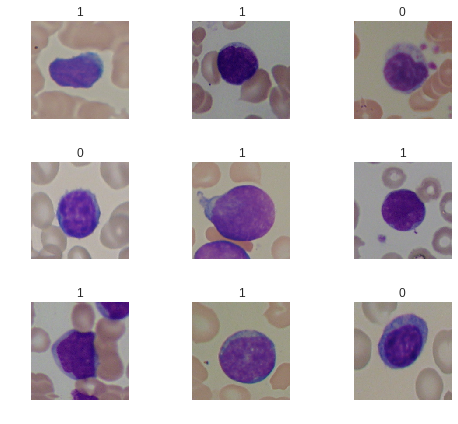

In [0]:
data.show_batch(rows=3, figsize=(7,6))

## View classes info
Now we can run the following code block which will print out the classes list and lengths.

In [0]:
print(data.classes)
len(data.classes),data.c

['0', '1']


(2, 2)

# The Resnet34 model

## What and why to use transfer learning?

Transfer learning is meaning use a pre-trained model to build our classifier. A pre-trained model is a model that has been previously trained on a dataset. The model comprehends the updated weights and bias.  Using pre-trained model you are saving time and computational resources. Another vantage is that pre-trained models often perform better that architecture designed from scratch. To better understand this point, suppose you want to build a classifier able to sort different sailboat types. A model pre-trained on ships would have already capture in its first layers some boat features, learning faster and with better accuracy among the different sailboat types.

## The Resnet34 architecture

Resnet34 generally is considered a good choice as first architecture to test, it shows good performance without an excessive size allowing to use a higher batch size and thus less computation time. For this reason, before to test more complex architectures (such as Resner5o and so on) Resnet34 is a good compromise.

Residual net have been ideated to solve the problem of the **vanishing gradient**. Highly intricate networks with a large number of hidden layer are working effectively in solving complicated tasks. Their structures allow them to catch pattern in complicated data. When we train the network the early layer tend to be trained slower (the gradient are smaller during backpropagation). The initial layers are important because they learn the basic feature of an object (edge, corner and so on). Failing to proper train these layers lead to a decrease in the overall accuracy of the model.

**Residual neural network** have been ideated to solve this issue. The Resnet model presents the possibility to skip the training of some layer during the initial training. The skipped layer is reusing the learned weights from the previous layer. [Original research article](https://arxiv.org/pdf/1512.03385.pdf)

# Test the Resnet34 architecture with our dataset
Now we are going to test how the FastaAI implementation of Resnet34 works with the ALL_IDB2 dataset. 

## Create the convolutional neural network

First we will create the convolutional neural network based on Resnet34, to do this we can use the following code block which uses FastAI  ( [*cnn_learner*](https://docs.fast.ai/vision.learner.html#cnn_learner) previously *create_cnn*) function. We pass the loaded data, specify the resnet34model, pass error_rate & accuracy as a list for the metrics parameter specifying we want to see both error_rate and accuracy,  and finally specify a weight decay of 1e-1 (1.0).

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy], wd=1e-1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 65794006.36it/s]


# learn.lr_find() & learn.recorder.plot()
Now we will use the [learn.lr_find()](https://docs.fast.ai/basic_train.html#lr_find) function to run LR Finder. LR Finder help to find the best learning rate to use with our network. For more information the [original paper](https://arxiv.org/pdf/1506.01186.pdf). 
As shown from the output of above,  [learn.recorder.plot()](https://docs.fast.ai/basic_train.html#Recorder.plot) function plot the loss over learning rate. Run the following code block to view the graph. The best learning rate should be chosen as the learning rate value where the curve is the steepest. You may try different learning rate values in order to pick up the best.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


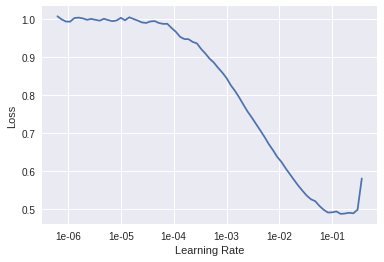

In [0]:
learn.lr_find()
learn.recorder.plot()

# learn.fit_one_cycle() & learn.recorder.plot_losses()
The [learn.fit_one_cycle()](https://docs.fast.ai/basic_train.html#fit_one_cycle) function can be used to fit the model. Fit one cycle reach a comparable accuracy faster than th *fit* function in training of complex models. Fit one cycle instead of maintain fix the learning rate during all the iterations is linearly increasing the learning rate and then it is decreasing again (this process is what is called one cycle). Moreover, this learning rate variation is helping in preventing overfitting. We use 5 for the parameter *cyc_len* to specify the number of cycles to run (on cycle can be considered equivalent to an epoch), and *max_lr* to specify the maximum learning rate to use which we set as *0.001*. Fit one cycle varies the learning rate from 10 fold less the maximum learning rate selected. For more information about fit one cycle: [article](https://arxiv.org/pdf/1803.09820.pdf). We then use [learn.recorder.plot_losses()](https://docs.fast.ai/basic_train.html#Recorder.plot_losses) to plot the losses from *fit_one_cycle* as a graph.

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.954554,0.741058,0.480769,0.519231,00:29
1,0.809379,0.643883,0.365385,0.634615,00:03
2,0.685432,0.564404,0.250000,0.750000,00:03
3,0.588224,0.473878,0.192308,0.807692,00:03
4,0.515111,0.406535,0.153846,0.846154,00:03


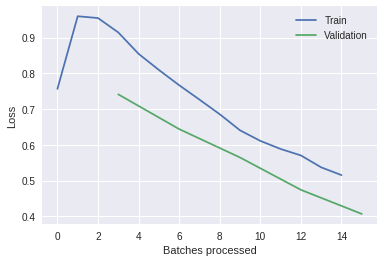

In [0]:
lr = 0.001
learn.fit_one_cycle(cyc_len=5, max_lr=lr)
learn.recorder.plot_losses()

# Save the model

We can save the model once it has been trained.

In [0]:
learn.save('resnet34_model')

# learn.recorder.plot_lr()
We use  [learn.recorder.plot_lr()](https://docs.fast.ai/basic_train.html#Recorder.plot_lr) to plot the learning rate.

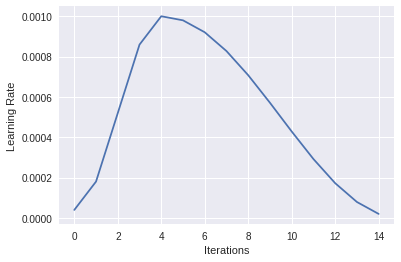

In [0]:
learn.recorder.plot_lr()

# ClassificationInterpretation()
We use  [ClassificationInterpretation()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) to visualize interpretations of our model.

In [0]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

# interp.plot_top_losses()
We can use [interp.plot_top_losses()](https://docs.fast.ai/vision.learner.html#plot_top_losses) to view our top losses and their details.

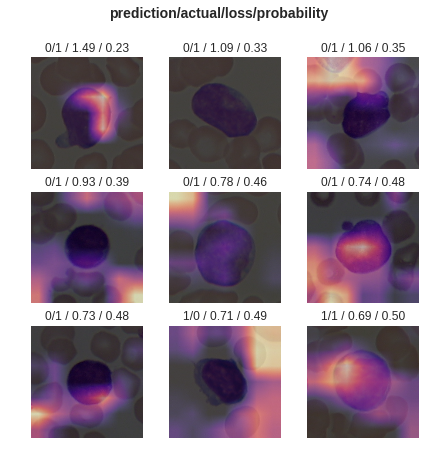

In [0]:
interp.plot_top_losses(9, figsize=(7,7))

# interp.plot_confusion_matrix()
Now we will use  [interp.plot_confusion_matrix()](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation.plot_confusion_matrix) to display a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Below, 24 in the top left square represents 24 true negatives, while 1 in the top right square represents 1 false positives, 7 in the bottom left square represents 7 false negatives, and 20 in the bottom right represents 20 true positives.

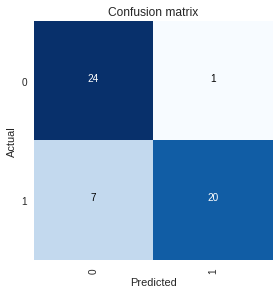

In [0]:
interp.plot_confusion_matrix()

# learn.unfreeze()
Next we use [learn.unfreeze()](https://docs.fast.ai/basic_train.html#Learner.unfreeze) to unfreeze the model. Resnet34 model was trained on ImageNet to classify images among 1000 categories. None of these categories is a leukemia cell, for these reason when fast.ai *cnn_learner* function is behind line substituting the last layer with 2 other layers. The last layer is a matrix that has the same size of our data class (*data.c*). Before, we just trained these two layers while the other model's layers were still keeping the downloaded weight. Unfreezing our model allow us to train also these other layers and updates their weights.


In [0]:
learn.unfreeze()

# Train the entire (unfrozen) model
Now that we have unfrozen our model, we will use the following code blocks to train the whole model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


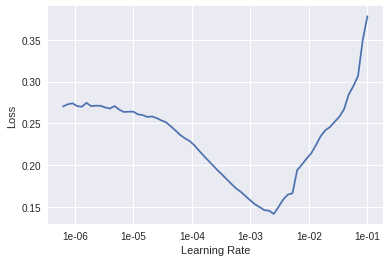

In [0]:
learn.lr_find()
learn.recorder.plot()

#Slice parameter

Initial layers are activated by simple patterns (like edge, lines, circles etc...)  while the following layers are acquiring the ability to recognize more sophisticated patterns. Update too much the weight of these layers would probably decrease our accuracy. The scope of transfer learning is to exploit this ability of a pre-trained model in recognizing particular patterns and to adapt to our dataset. The parameter *slice* allows to apply ** discriminative learning rate**. In other words, we apply a smaller learning rate (in this case, 1e-5) to the earlier layer and a higher learning rate to the last layer.


In [0]:
nlr = slice(1e-5, 1e-3)
learn.fit_one_cycle(5, nlr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.294978,0.321443,0.134615,0.865385,00:03
1,0.264956,0.214495,0.096154,0.903846,00:03
2,0.218917,0.145079,0.076923,0.923077,00:03
3,0.189562,0.114834,0.057692,0.942308,00:03
4,0.157575,0.098114,0.057692,0.942308,00:03


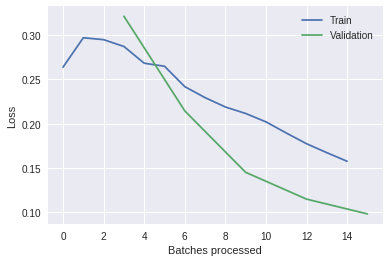

In [0]:
learn.recorder.plot_losses()

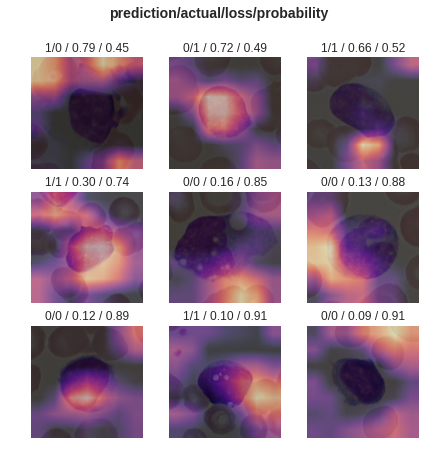

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_top_losses(9, figsize=(7,7))

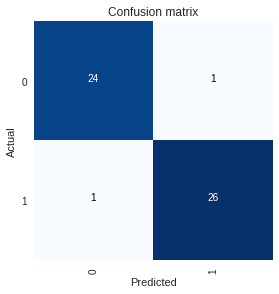

In [0]:
interp.plot_confusion_matrix()

# Save the model

We save our model after the un-freezing

In [0]:
learn.save('resnet34_unfreeze')